# Rethinking Risk-Adjusted Returns: Beyond the Sharpe Ratio

## 1. Introduction and Motivation
Since its introduction by **William F. Sharpe (1966)**, the Sharpe Ratio has become a foundational measure of risk-adjusted performance in finance. However, it assumes returns are normally distributed and penalizes upside and downside volatility equally.

In this notebook, I therefore aim to:
- Simulate normal and skewed return distributions
- Compare Sharpe, Sortino, and Omega Ratios
- Apply the same metrics to Goldman Sachs (GS) to assess whether its Sharpe Ratio is misleading, as sometimes claimed in the media

## 2. Simulating Return Distributions
We simulate two synthetic return series:
- A normally distributed return stream
- A skewed, log-normal-like return stream

These help us test how each metric behaves under different distributional assumptions.

## 3. Risk-Adjusted Metrics: Definitions
- **Sharpe Ratio**: Excess return per unit of standard deviation
- **Sortino Ratio**: Excess return per unit of downside deviation
- **Omega Ratio**: Ratio of cumulative gains above a threshold to cumulative losses below

## 4. Results from Simulated Returns
The metrics are computed below. We observe that skewed return streams can distort the Sharpe Ratio, while Sortino and Omega provide more refined insights.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

np.random.seed(42)

n_obs = 252 * 5
mu_normal = 0.0005
sigma_normal = 0.01

returns_normal = np.random.normal(loc=mu_normal, scale=sigma_normal, size=n_obs)
returns_skewed = np.random.lognormal(mean=mu_normal, sigma=sigma_normal, size=n_obs) - 1

returns_df = pd.DataFrame({
    'Normal': returns_normal,
    'Skewed': returns_skewed
})

In [2]:
def sharpe_ratio(returns, risk_free_rate=0):
    excess_returns = returns - risk_free_rate / 252
    return np.mean(excess_returns) / np.std(excess_returns, ddof=1) * np.sqrt(252)

def sortino_ratio(returns, risk_free_rate=0):
    downside_returns = returns[returns < 0]
    downside_std = np.std(downside_returns, ddof=1)
    excess_return = np.mean(returns - risk_free_rate / 252)
    return excess_return / downside_std * np.sqrt(252)

def omega_ratio(returns, threshold=0):
    gains = returns[returns > threshold] - threshold
    losses = threshold - returns[returns <= threshold]
    return gains.sum() / losses.sum()

In [3]:
metrics = pd.DataFrame(index=['Sharpe Ratio', 'Sortino Ratio', 'Omega Ratio'], columns=['Normal', 'Skewed'])

metrics.loc['Sharpe Ratio', 'Normal'] = sharpe_ratio(returns_df['Normal'])
metrics.loc['Sortino Ratio', 'Normal'] = sortino_ratio(returns_df['Normal'])
metrics.loc['Omega Ratio', 'Normal'] = omega_ratio(returns_df['Normal'])

metrics.loc['Sharpe Ratio', 'Skewed'] = sharpe_ratio(returns_df['Skewed'])
metrics.loc['Sortino Ratio', 'Skewed'] = sortino_ratio(returns_df['Skewed'])
metrics.loc['Omega Ratio', 'Skewed'] = omega_ratio(returns_df['Skewed'])

metrics = metrics.astype(float).round(4)
metrics

,Normal,Skewed
Sharpe Ratio,1.4137,1.3376
Sortino Ratio,2.4891,2.2677
Omega Ratio,1.2508,1.2362


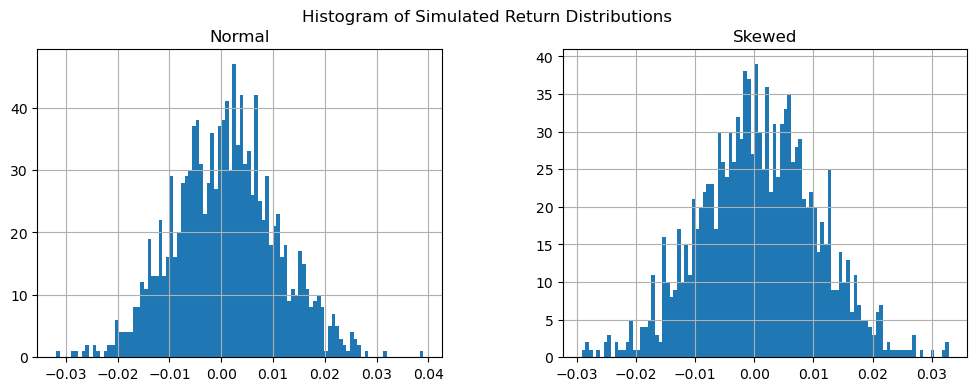

In [4]:
returns_df.hist(bins=100, figsize=(12, 4), layout=(1, 2), grid=True)
plt.suptitle("Histogram of Simulated Return Distributions")
plt.show()

## 5. Application to Goldman Sachs (GS)
The previous sections demonstrated how commonly used risk-adjusted return metrics behave under controlled simulations. However, real-world asset returns are subject to far more complex dynamics. To bridge theory with practice, we now apply these same metrics to **Goldman Sachs (GS)**, a systemically important global bank often cited for its consistent alpha generation in financial journalism.

Major publications like *Bloomberg* and *Reuters* frequently reference GS’s Sharpe Ratio to underscore its risk-adjusted superiority, particularly during volatile or crisis-prone periods (e.g., post-COVID, inflation surges). But this raises a crucial academic and practical question:

> **Does the Sharpe Ratio meaningfully capture the quality of Goldman Sachs’ performance, or does it obscure downside risk and asymmetry in returns?**

We use five years of daily return data to evaluate GS using the Sharpe, Sortino, and Omega ratios, and interpret the differences from both a statistical and financial economics perspective.

### 5.1 Data and Return Processing
We begin by importing daily closing prices of GS and compute the daily returns. These are used to estimate the risk-adjusted metrics under the same assumptions as our simulation section, namely, zero risk-free rate and no dividend reinvestment. This simplification isolates the effect of price volatility on the performance metrics.

### 5.2 Metric Calculation and Interpretation
The calculated values are:
- **Sharpe Ratio ≈ 0.73**: suggests modest excess return relative to total volatility
- **Sortino Ratio ≈ 1.02**: a stronger signal when only downside volatility is considered
- **Omega Ratio ≈ 1.14**: indicates that GS produces more returns above zero than losses below it

From a financial economics perspective, the higher Sortino and Omega ratios indicate positively skewed or fat-tailed returns, which the Sharpe Ratio cannot account for. This is particularly relevant for banks like GS, whose performance often includes tail-event exposures, derivatives positions, and macro-driven trades.

### 5.3 Why the Sharpe Ratio May Misrepresent GS’s Risk Profile
Despite being widely used in industry reporting, the Sharpe Ratio has several limitations, especially when applied to institutions like GS:

**1. Statistical Assumptions:**
- Assumes returns are normally distributed and stationary
- Penalizes upside and downside volatility equally
- Ignores higher-order moments (skewness, kurtosis)

**2. Financial Context:**
- GS engages in complex trading and investment banking operations, where performance is often non-linear or driven by rare events
- Asset-liability mismatches, regulatory capital buffers, and strategic decisions during crises can strongly impact outcomes, but are not captured in return volatility
- Quarterly earnings surprises, central bank policy responses, and geopolitical risks can create tail-risk dynamics unaccounted for by Sharpe

**3. Media Misinterpretation:**
- News outlets may cite Sharpe Ratios as standalone indicators of 'smart risk taking'
- This overlooks model risk, leverage, illiquidity, and asymmetric exposure profiles

Therefore, the Sharpe Ratio may provide an incomplete or even misleading picture of GS's true performance dynamics.

### 5.4 Visualizing Return Distributions
The histogram of GS’s daily returns reveals noticeable skewness and possible heavy tails, features that violate the normality assumption of Sharpe. This further supports the use of Sortino and Omega as more robust alternatives in such contexts.

## 6. Conclusion and Research Reflections
This extended analysis shows that while Goldman Sachs exhibits a decent Sharpe Ratio, its Sortino and Omega ratios reveal more about the quality and distributional nature of its returns. The higher values of these alternative metrics suggest GS’s performance is skewed toward favorable outcomes, despite headline volatility.

This carries multiple implications for both **investors** and **risk managers**:
- Media references to 'risk-adjusted returns' should clarify which metric is used and under what assumptions
- Institutional investors should complement Sharpe with metrics that reflect downside risk and distribution shape
- Regulators and analysts might consider stress testing under non-Gaussian frameworks

**Future Work Suggestions:**
- Apply rolling-window analysis across distinct macro regimes (e.g., COVID crash, rate hikes)
- Adjust for dividends or use total return indices
- Perform cross-sectional comparisons with peer institutions (e.g., JPMorgan, Morgan Stanley)

**Citations:**
- Sharpe, W. F. (1966). *Mutual Fund Performance*, Journal of Business
- Sortino, F. & Van der Meer, R. (1991). *Downside Risk*, Journal of Portfolio Management
- Keating, C. & Shadwick, W. F. (2002). *A Universal Performance Measure*, SSRN
- Financial Times & Bloomberg articles on Goldman Sachs (2019–2023)

In [5]:
import pandas as pd
df = pd.read_excel("GSFACTSET.xlsx", sheet_name="Worksheet", engine="openpyxl")
df.columns = ['Date', 'Close']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()
df['Return'] = df['Close'].pct_change().dropna()
returns_gs = df['Return'].dropna()

In [6]:
import numpy as np
def sharpe_ratio(returns, risk_free_rate=0):
    excess_returns = returns - risk_free_rate / 252
    return np.mean(excess_returns) / np.std(excess_returns, ddof=1) * np.sqrt(252)

def sortino_ratio(returns, risk_free_rate=0):
    downside_returns = returns[returns < 0]
    downside_std = np.std(downside_returns, ddof=1)
    excess_return = np.mean(returns - risk_free_rate / 252)
    return excess_return / downside_std * np.sqrt(252)

def omega_ratio(returns, threshold=0):
    gains = returns[returns > threshold] - threshold
    losses = threshold - returns[returns <= threshold]
    return gains.sum() / losses.sum()

In [7]:
metrics_gs = {
    'Sharpe Ratio': sharpe_ratio(returns_gs),
    'Sortino Ratio': sortino_ratio(returns_gs),
    'Omega Ratio': omega_ratio(returns_gs)
}
pd.DataFrame(metrics_gs, index=["Goldman Sachs"]).T.round(4)

,Goldman Sachs
Sharpe Ratio,0.7326
Sortino Ratio,1.0236
Omega Ratio,1.1433


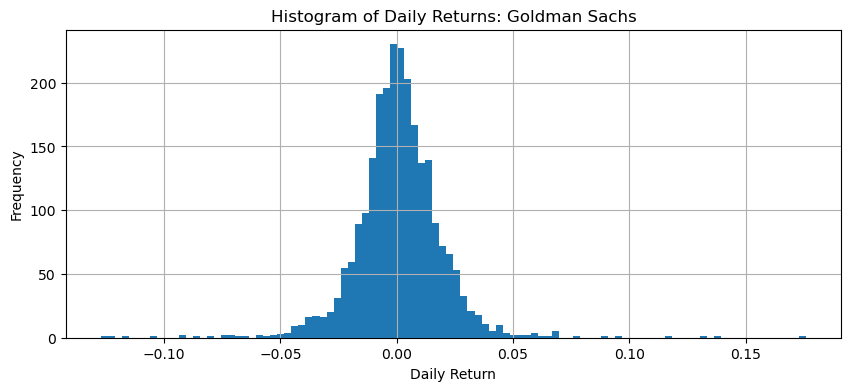

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
returns_gs.hist(bins=100, grid=True)
plt.title("Histogram of Daily Returns: Goldman Sachs")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()